# GPS pipeline and plotting

by Jasmin L. Walter

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns

import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators

import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby


from os.path import exists


import scipy.stats

from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp

import scipy.signal
import glob

In [9]:
datapath_gps_emloid = "F:\\Cyprus_project_overview\\data\\GPS_data\\emloid\\explorationSessions"
datapath_gps_goPro = "F:\\Cyprus_project_overview\\data\\GPS_data\\goPro"

savepath = "F:/Cyprus_project_overview/data/analysis/gps/walkingPaths"

datapath_map = "F:\\Cyprus_project_overview\\data\\maps"
filename_map = "Limassol_grey2.jpg"

In [22]:
# gps slice info
datapath_gps_slice = "F:\\Cyprus_project_overview\\data\\GPS_data"
sliceOverview = "synchro_gps_imu.csv"

df_gps_slice = pd.read_csv(os.path.join(datapath_gps_slice, sliceOverview))

df_gps_slice.head(10)

,session,ET_start,ET_end,ET_start_time,ET_end_time,GPS_start,GPS_end,GPS_start_time,GPS_end_time
0,Expl_1_ET_1_C1,13670,14462,2023-09-05 09:03:52.544755555,2023-09-05 09:04:18.952688888,3331,3475,2023-09-05 09:04:09.000,2023-09-05 09:04:37.800
1,Expl_1_ET_1_C2,32923,33669,2023-09-05 09:14:34.488733333,2023-09-05 09:14:59.360800000,6123,6256,2023-09-05 09:14:50.400,2023-09-05 09:15:17.000
2,Expl_1_ET_2_C1,9893,10828,2023-09-05 09:39:54.704611111,2023-09-05 09:40:25.880633333,2405,2550,2023-09-05 09:40:12.000,2023-09-05 09:40:41.000
3,Expl_1_ET_2_C2,28810,29501,2023-09-05 09:50:25.444700000,2023-09-05 09:50:48.484555555,5540,5660,2023-09-05 09:50:43,2023-09-05 09:51:07
4,Expl_1_ET_3_C1,8075,8940,2023-09-05 10:14:31.229344444,2023-09-05 10:15:00.068955555,2124,2245,2023-09-05 10:14:48.200,2023-09-05 10:15:12.400
5,Expl_1_ET_3_C2,29530,30262,2023-09-05 10:26:26.593522222,2023-09-05 10:26:51.000911111,5297,5415,2023-09-05 10:26:44.000,2023-09-05 10:27:07.600
6,Expl_2_ET_1_C1,11613,12362,2023-09-06 07:43:04.835755555,2023-09-06 07:43:29.811788888,2420,2592,2023-09-06 07:43:17.000,2023-09-06 07:43:51.400
7,Expl_2_ET_1_C2,30686,31330,2023-09-06 07:53:40.779733333,2023-09-06 07:54:02.251766666,5585,5690,2023-09-06 07:53:57.800,2023-09-06 07:54:18.800
8,Expl_2_ET_2_C1,8624,9306,2023-09-06 08:13:24.987155555,2023-09-06 08:13:47.727244444,1795,1901,2023-09-06 08:13:41.600,2023-09-06 08:14:02.800
9,Expl_2_ET_2_C2,27979,28557,2023-09-06 08:24:10.331144444,2023-09-06 08:24:29.603155555,5012,5088,2023-09-06 08:24:30.200,2023-09-06 08:24:45.400


In [5]:

#converting .pos file to dataframe
def pos_to_dataframe(file):
    """
    Converts .pos data to dataframe with timestamp, latitude, longitude and height

    """
    df = pd.read_table(file, sep="\s+", header=9, parse_dates={"Timestamp": [0, 1]})
    df = df.rename(
        columns={
            "Timestamp": "time",
            "longitude(deg)": "longitude",
            "latitude(deg)": "latitude",
        }
    )
    return df


In [23]:
def slice_gps_data(data, indexSess, indexET):
    
    # add all slicing information
    startP = 0
    endP = 0
    
    
    if indexSess == 1:
        if indexET == 1:           
            startP = 3530
            endP = 6090
            
        elif indexET == 2:
            startP = 2570
            endP = 5540
            
        elif indexET == 3:
            startP = 2245
            endP = 5295
        
        
    elif indexSess == 2:
        
        if indexET == 1:
            startP = 2592
            endP = 5595
            
        elif indexET == 2:
            startP = 1901
            endP = 5012
            

    
    elif indexSess == 3:
        if indexET == 1:
            startP = 2550
            endP = 5340
            
        elif indexET == 2:
            startP = 2054
            endP = 4710
            
            
        elif indexET == 3:
            startP = 1246
            endP = 4126

        
    elif indexSess == 4:
        if indexET == 1:
            startP = 1896
            endP = 4932
            
        elif indexET == 2:
            startP = 1903
            endP = 4864
        
    elif indexSess == 5:
        if indexET == 1:
            startP = 2522
            endP = 5246
            
        elif indexET == 2:
            startP = 2214
            endP = 4682

    else:
        print("wrong indexSess in slice_gps_data")
    
    
    
    
    sliced_data = data.loc[startP:endP]
    
    return sliced_data



In [28]:
# load and process the data
testRun = True

if not testRun:
    
    maxSess = 5
    maxET = 3 # unless in session 2,4,5
else:
    maxSess = 1
    maxET = 1 # unless in session 2,4,5



for indexSess in range(1, maxSess + 1):
    
    if not testRun:
    
        if indexSess == 2 | indexSess == 4 | indexSess == 5:
            maxET = 2
        else:
            maxET = 3
    else:
        maxET = 1
    
    for indexET in range(1, maxET +1):
        
        folder = "Expl_" + str(indexSess) + "_ET_" + str(indexET) + "_GPS"
        file_pattern = "reach_rover_raw_*.pos"

        # Use glob to find all matching files in the folder
        file_path_pattern = os.path.join(datapath_gps_emloid, folder, file_pattern)
        matching_files = glob.glob(file_path_pattern)
        filtered_files = [f for f in matching_files if "_events" not in os.path.basename(f)]

        # Check if any matching files are found
        if len(filtered_files) == 1:
            # Assuming you want to use the first matching file
            data = pos_to_dataframe(matching_files[0])
        elif len(filtered_files) == 0:
            print("No matching files found for: Expl_" + str(indexSess) + "_ET_" + str(indexET) + "_GPS")
        else:
            print("too many files found for Expl_" + str(indexSess) + "_ET_" + str(indexET) + "_GPS")
        
        print(len(data))
        data = slice_gps_data(data, indexSess, indexET)
        print(len(data))
        
        
        
        
    
    

8017
2561


NameError: name 'filepath_img_save' is not defined

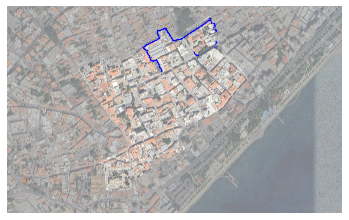

In [29]:
# plot this 


#give the information on filepath of map image 
filepath_map_general = "F:\\Cyprus_project_overview\\data\\maps"
filename_map = "Limassol_grey2"

#put together the filepath name
filepath_map = filepath_map_general + "\\" + filename_map + ".jpg"

# Load an image from file
img = Image.open(filepath_map) 


#assign the cleaned dataframe 
df = data
df_name = "testi" # for printing later on plot


# pixel values map picture 
pixel_width = 8192  # Width of the image in pixels
pixel_height = 5051  # Height of the image in pixels


# latitude and longitude of the edges of the map image 
corner_lat_top = 34.67751  # Latitude of the top edge of the map
corner_lat_bottom = 34.671293  # Latitude of the bottom edge of the map
corner_lon_left = 33.037658  # Longitude of the left edge of the map
corner_lon_right =  33.049882 # Longitude of the right edge of the map

# Calculate differences in latitude and longitude
delta_lat = corner_lat_top - corner_lat_bottom
delta_lon = corner_lon_right - corner_lon_left

# Calculate conversion ratio from degrees to pixels
lat_to_pixel = pixel_height / delta_lat
lon_to_pixel = pixel_width / delta_lon

# Assuming df contains 'latitude' and 'longitude' columns
# Convert GPS coordinates to pixel coordinates
df['x'] = (df['longitude'] - corner_lon_left) * lon_to_pixel
df['y'] = (corner_lat_top - df['latitude']) * lat_to_pixel


# Now, df['x'] and df['y'] contain the pixel coordinates of the GPS points on the image
# Plot these points on the map image
plt.imshow(img, alpha=0.6)
plt.scatter(df['x'], df['y'], color='blue', marker='.', s=0.01)
#plt.title("All Exploration Sessions", fontsize=7, loc="center")
# Manually position the title at the lower left corner
#plt.text(5, 5340, df_name, fontsize=6, ha='left', va='top')
#plt.text(5, 5340, "top: " + str(corner_lat_top) + " " + "down: " + str(corner_lat_bottom) + " " + "left: " + str(corner_lon_left) + " " + "right: " + str(corner_lon_right), fontsize=6, ha='left', va='bottom')

# Hide the axes
plt.axis("off")

# Save the figure as an image with a specific DPI
plt.savefig(filepath_img_save, dpi=600, bbox_inches = "tight")  # Set the output file and resolution (dpi)

plt.show()

In [18]:
    
print(filtered_files)
print(len(filtered_files))
print(len(matching_files))

['F:\\Cyprus_project_overview\\data\\GPS_data\\emloid\\explorationSessions\\Expl_1_ET_1_GPS\\reach_rover_raw_202309050852.pos']
1
2
